# Quotient Python SDK Demo

Documentation for the `quotientai` CLI and SDK can be found at [docs.quotientai.co](docs.quotientai.co).

### Prerequisites
- Python 3.10 or higher
- Quotient account and API key (see our [quickstart guide](https://docs.quotientai.co/sdk-reference/get-started))

### Overview

In this notebook, we will demo the experimentation process for evaluating models on their ability to answer questions about the IRS 1040 and Schedule C tax forms. We compare performance between OpenAI's `o1` model and DeepSeek's `R1` model. Each model will be given the same, generic question-answering prompt, where they will be provided with context from the tax form instructions as well as a question.

## Setup

In [ ]:
import os
import time
import pandas as pd
from matplotlib import pyplot as plt

from quotientai import QuotientAI

In [ ]:
# Add your API key here or set it as an environment variable
quotient_api_key = "fill_in_here"

os.environ['QUOTIENT_API_KEY'] = quotient_api_key

# Initialize Quotient
quotient = QuotientAI()

# IRS Form Instruction Question Answering

## Adding your dataset

### Notes:
- The column representing the input to the LLM must be named `input`
- The column representing the expected answer from the LLM must be named `expected`
- `Optional`: You can provide a `context` column to the dataset to add in any context you pull in from external sources like vector databases.

The IRS question-answering dataset contains 200 question-context-answer triplets. We will be running the evaluation on a subset of 50 of them. 

In [98]:
# Load Dataset from HuggingFace
# Note, you may need to login using e.g. `huggingface-cli login` to access this dataset
irs_qa = pd.read_parquet("hf://datasets/quotientai/irs_form_instruction_qa_pairs/tax_form_instructions_qa_pairs.parquet", 
                         columns=["context","question", "answer"])

# Rename columns to match the expected format
irs_qa = irs_qa.rename(columns={"question": "input", "answer": "expected"})

# We will use the first 50 rows for this demo
irs_qa_sample = irs_qa.head(50)

irs_qa_sample.head()

,context,input,expected
426,Include fees for tax advice related to your bu...,What expenses should be included on Line 18 of...,"On Line 18, you should include your expenses f..."
90,![This is an Image: box.gif](/pub/xml_bc/box.g...,What should I enter on line 10 if I am married...,If you are married filing separately and lived...
7,**Changes to reporting amounts from Form 1099-...,What should I do if I received a Form 1099-K s...,"Beginning in 2024, if you received a Form 1099..."
33,#### Foster child.\n\nA foster child is any ch...,Can I file as a Qualifying Surviving Spouse if...,"No, you cannot file as a Qualifying Surviving ..."
396,**Single-member limited liability company (LLC...,What tax form should a single-member LLC file ...,A single-member LLC with employees must file e...


To upload the data to Quotient, you can run the following cell. 

Keep in mind, the data must be formatted as a list of dictionaries. If a dataset with the desired name already exists, **the data will be appended onto the existing dataset**. 

In [ ]:
# Create a dataset in Quotient
dataset_name = "demo-irs-form-instruction-qa"

# First check to see if we already have a dataset with this name
existing_dataset = [dataset for dataset in quotient.datasets.list() if dataset.name==dataset_name]

# Only create the dataset if it does not already exist
# Warning: creating a dataset with the same name as an existing dataset will append rows onto the existing dataset
if len(existing_dataset) == 0:
    dataset = quotient.datasets.create(
        name=dataset_name,
        rows=irs_qa_sample.to_dict(orient='records'), # convert dataframe to list of dictionaries
    )
    print(f"Dataset {dataset_name} created")
# If the dataset already exists, save the dataset object
else:
    print(f"Dataset {dataset_name} already exists")
    dataset = existing_dataset[0]

Dataset demo-irs-form-instruction-qa created


## Creating your prompt

We will use a simple system and user prompt for this task. If a prompt with the desired name already exists, you will get an error. If you wish to create a new version of an existing prompt, you may use the `quotient.prompts.update()` method instead.

P

In [ ]:
# Let's start with a simple system and user prompt
prompt_name = "quotient-demo-prompt-v1"

system_prompt_v1 = "You are a tax professional helping answer user questions about their tax form."

user_prompt_v1 = """
Question:
{{input}}

Context:
{{context}}
"""

In [ ]:
# First check to see if we already have a prompt with this name
existing_prompt = [prompt for prompt in quotient.prompts.list() if prompt.name==prompt_name]

# Only create the prompt if it does not already exist
# Warning: creating a prompt with the same name as an existing prompt will output an error
if len(existing_prompt) == 0:
    # create your prompt with Quotient
    prompt = quotient.prompts.create(
        name=prompt_name,
        system_prompt=system_prompt_v1,
        user_prompt=user_prompt_v1,
    )
    print(f"Prompt {prompt_name} created")

    print(f"\nSYSTEM PROMPT:\n{prompt.system_prompt}")
    print(f"\nUSER PROMPT:\n{prompt.user_prompt}")
    
# If the prompt already exists, save the prompt object
else:
    print(f"Prompt {prompt_name} already exists")
    prompt = existing_prompt[0]

    print(f"\nSYSTEM PROMPT:\n{prompt.system_prompt}")
    print(f"\nUSER PROMPT:\n{prompt.user_prompt}")


Prompt quotient-demo-prompt-v1 created

SYSTEM PROMPT:
You are a tax professional helping answer user questions about their tax form.

USER PROMPT:

Question:
{{input}}

Context:
{{context}}



## Picking Metrics

The following metrics are supported. If you would like to see any additional metrics that are not on this list, please don't hesistate to contact us.

In [8]:
quotient.metrics.list()

['bertscore',
 'exactmatch',
 'faithfulness_selfcheckgpt',
 'sentence_tranformers_similarity',
 'f1score',
 'jaccard_similarity',
 'knowledge_f1score',
 'meteor',
 'normalized_exactmatch',
 'rouge_for_context',
 'rouge1',
 'rouge2',
 'rougeL',
 'rougeLsum',
 'sacrebleu',
 'verbosity_ratio']

For this analysis, we will be considering:
- `rougeL`
- `verbosity_ratio`
- `bertscore`
- `faithfulness_selfcheckgpt`
- `sentence_tranformers_similarity`

In [ ]:
metrics = [
    'rougeL',
    'verbosity_ratio',
    'bertscore',
    'faithfulness_selfcheckgpt',
    'sentence_tranformers_similarity'
 ]

## Picking a model

In [ ]:
# get the list of supported models
models = quotient.models.list()

for m in models:
    print(m.name)

gpt-4
gpt-4o
gpt-4o-2024-05-13
gpt-4-turbo-preview
gpt-4-0613
gpt-4-turbo
gpt-4-turbo-2024-04-09
gpt-4-1106-preview
gpt-4-0125-preview
gpt-3.5-turbo
gpt-3.5-turbo-1106
gpt-3.5-turbo-0125
claude-2.1
claude-3-haiku-20240307
claude-3-opus-20240229
claude-3-sonnet-20240229
claude-3-5-sonnet-20240620
vertex_ai/chat-bison
vertex_ai/chat-bison@002
vertex_ai/gemini-pro
vertex_ai/gemini-1.5-pro
vertex_ai/gemini-1.5-flash-preview-0514
vertex_ai/gemini-1.5-pro-preview-0514
databricks/databricks-dbrx-instruct
databricks/databricks-meta-llama-3-70b-instruct
databricks/databricks-mixtral-8x7b-instruct
gemini-1.5-pro-002
claude-3-5-sonnet-20241022
gemini-1.5-flash-002
vertex_ai/meta/llama-3.2-90b-vision-instruct-maas
claude-3-5-haiku-20241022
together_ai/deepseek-ai/DeepSeek-R1
o1-preview
o1-mini
gpt-4o-mini-2024-07-18
together_ai/mistralai/Mistral-7B-Instruct-v0.1


In [11]:
# get OpenAI's o1-preview model
# note: must use the exact name of the model
o1_model = quotient.models.get("o1-preview")

## Running an evaluation

To start an evaluation run, you must specify the desired prompt, dataset, model, model parameters, and metrics. Since `o1` is a reasoning model, it does not accept `temperature` or `top_p` as parameters.

In [ ]:
# create a run with all of the metrics we care about
o1_run = quotient.evaluate(
    prompt=prompt,
    dataset=dataset,
    model=o1_model,
    parameters={
        "max_tokens": 1500,
    },
    metrics=metrics,
)

# get the run ID and status
print("Run ID:", o1_run.id)

Run ID: b3580593-cb83-44dc-8d70-243afc069e23


In [ ]:
# wait for the run to finish
while quotient.runs.get(o1_run.id).status in ["not-started", "running"]:
    time.sleep(10)
    pass

print("Status: ", quotient.runs.get(o1_run.id).status)

# get the run results
o1_run_results = quotient.runs.get(o1_run.id).results

o1_run_results[:1]

Status:  completed


[{'id': 'f16e3471-42c1-421b-aff0-fab10d133ded',
  'input': 'What types of expenses can be included as deductions on line 12 of the IRS tax form?',
  'output': 'On **line 12** of **Schedule 1 (Form 1040)**, you can deduct certain unreimbursed employee business expenses if you are one of the following qualified individuals:\n\n1. **Armed Forces Reservists**:\n   - **Who qualifies**: Members of the National Guard or reserve components of the U.S. Armed Forces.\n   - **Deductible expenses**: Unreimbursed travel expenses incurred while performing services as a reservist more than 100 miles away from home. This includes expenses for transportation, lodging, and meals (subject to the 50% limit on meal expenses).\n   - **How to claim**: Complete **[Form 2106](https://www.irs.gov/forms-pubs/about-form-2106)** to calculate your deductible expenses and include the deduction on line 12.\n\n2. **Qualified Performing Artists**:\n   - **Who qualifies**: Performing artists who meet all the following c

Evaluation run results are returned as a list of dictionaries (one dictionary of results per row).

In [62]:
# convert the results to a pandas DataFrame for easier viewing, and clean up the column names
o1_results_df = pd.json_normalize(o1_run_results)
o1_results_df.columns = o1_results_df.columns.str.replace("values.", "")

o1_results_df.head(2)

,id,input,output,created_at,created_by,context,expected,knowledge_f1score,rougeL.precision,rougeL.recall,rougeL.f1,verbosity_ratio,bertscore.precision,bertscore.recall,bertscore.f1,faithfulness_selfcheckgpt,sentence_tranformers_similarity
0,f16e3471-42c1-421b-aff0-fab10d133ded,What types of expenses can be included as dedu...,"On **line 12** of **Schedule 1 (Form 1040)**, ...",2025-02-24T15:57:25.310248,9842a2b1-f666-4e18-9233-7cb0694355f9,Include the following deductions on \nline 12...,"On line 12, you can include deductions for cer...",0.396040,0.107143,0.765957,0.18799,7.666667,0.519463,0.698987,0.596000,0.235826,0.695160
1,c0b4c2c0-a16b-41a4-8881-b354fea83ac2,What percentage of business meal expenses can ...,**Answer:**\n\nIndividuals who are subject to ...,2025-02-24T15:58:24.776701,9842a2b1-f666-4e18-9233-7cb0694355f9,The standard meal allowance is the federal mea...,Individuals subject to the Department of Trans...,0.552036,0.174129,1.000000,0.29661,5.861111,0.544889,0.719462,0.620124,0.802549,0.923374


In [63]:
# view statistics on the results
o1_results_df.describe()

,knowledge_f1score,rougeL.precision,rougeL.recall,rougeL.f1,verbosity_ratio,bertscore.precision,bertscore.recall,bertscore.f1,faithfulness_selfcheckgpt,sentence_tranformers_similarity
count,44.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,44.000000,50.000000
mean,0.421435,0.142784,0.688717,0.204277,6.867114,0.484649,0.616980,0.541430,0.555248,0.743133
std,0.097360,0.164614,0.300584,0.151472,5.245580,0.193730,0.235497,0.209567,0.188713,0.289408
min,0.194030,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.189165,-0.082330
25%,0.365410,0.059347,0.644643,0.110127,2.724864,0.482252,0.658650,0.558782,0.431831,0.744678
50%,0.405253,0.104676,0.765332,0.177666,6.209309,0.522055,0.684906,0.595822,0.562262,0.829765
75%,0.487654,0.140843,0.873641,0.243180,11.066092,0.572030,0.719395,0.632118,0.684640,0.906366
max,0.628571,1.000000,1.000000,0.533333,22.846154,0.781119,0.823285,0.759155,0.893481,0.963188


## Testing a New Model

Next, we will run an evaluation on the same dataset and prompt, using the `DeepSeek-R1` model.

NOTE: While the `o1` model does not include the model reasoning, the model completion for `DeepSeek-R1` includes both the reasoning/thinking and the response text. Quotient returns this full output, but only evaluates against any text after the end of the reasoning (i.e. only text following the `</think>` token). This means that if the model does not complete the thinking step within the specified `max_tokens`, there will be no response text and the response will be considered as `None`.

In [ ]:
# Set the new model
deepseek_model = quotient.models.get("together_ai/deepseek-ai/DeepSeek-R1")

# create a run with all of the metrics we care about
deepseek_run = quotient.evaluate(
    prompt=prompt,
    dataset=dataset,
    model=deepseek_model,
    parameters={
        "max_tokens": 1500,
    },
    metrics=metrics,
)

print("Run ID:", deepseek_run.id)

Run ID: 8c91dd2a-14e1-4ce0-a772-8d358200ceb5


In [103]:
while quotient.runs.get(deepseek_run.id).status in ["not-started", "running"]:
    time.sleep(10)
    pass

print("Status: ", quotient.runs.get(deepseek_run.id).status)

# get the run results
deepseek_run_results = quotient.runs.get(deepseek_run.id).results

# convert the results to a pandas DataFrame for easier viewing, and clean up the column names
deepseek_results_df = pd.json_normalize(deepseek_run_results)
deepseek_results_df.columns = deepseek_results_df.columns.str.replace("values.", "")

deepseek_results_df.head(2)

Status:  completed


,id,input,output,created_at,created_by,context,expected,knowledge_f1score,rougeL.precision,rougeL.recall,rougeL.f1,verbosity_ratio,bertscore.precision,bertscore.recall,bertscore.f1,faithfulness_selfcheckgpt,sentence_tranformers_similarity,rougeL,bertscore
0,334eba89-071b-4c89-8e2a-521b7c26151d,What types of expenses can be included as dedu...,"<think>\nOkay, let's tackle this question abou...",2025-02-24T19:21:25.528905,9842a2b1-f666-4e18-9233-7cb0694355f9,Include the following deductions on \nline 12...,"On line 12, you can include deductions for cer...",0.381295,0.161458,0.659574,0.259414,4.222222,0.555956,0.730454,0.631370,0.486739,0.880093,NaN,NaN
1,426b90a4-387b-47e1-8fdf-651fcd7beaee,What percentage of business meal expenses can ...,"<think>\nOkay, let's tackle this question. The...",2025-02-24T19:22:38.376161,9842a2b1-f666-4e18-9233-7cb0694355f9,The standard meal allowance is the federal mea...,Individuals subject to the Department of Trans...,0.543689,0.225564,0.857143,0.357143,3.555556,0.548232,0.728883,0.625781,0.835164,0.912978,NaN,NaN


In [64]:
# view statistics on the results
deepseek_results_df.describe()

,knowledge_f1score,rougeL.precision,rougeL.recall,rougeL.f1,verbosity_ratio,bertscore.precision,bertscore.recall,bertscore.f1,faithfulness_selfcheckgpt,sentence_tranformers_similarity,rougeL,bertscore
count,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,0.0,0.0
mean,0.449712,0.156411,0.740019,0.244914,6.684316,0.548511,0.708916,0.617724,0.508562,0.849025,NaN,NaN
std,0.099849,0.098322,0.139289,0.123163,7.000538,0.062894,0.051344,0.056813,0.161678,0.069109,NaN,NaN
min,0.160377,0.018962,0.400000,0.037218,1.514620,0.357191,0.534878,0.428338,0.150244,0.638129,NaN,NaN
25%,0.384058,0.081579,0.627907,0.145199,3.543860,0.506644,0.686844,0.582580,0.395379,0.814459,NaN,NaN
50%,0.454054,0.128342,0.736842,0.205882,5.551724,0.546793,0.701902,0.616680,0.500755,0.849087,NaN,NaN
75%,0.508333,0.192308,0.846154,0.300752,7.685714,0.580631,0.730454,0.657798,0.605395,0.908473,NaN,NaN
max,0.660944,0.460526,1.000000,0.598291,50.285714,0.704239,0.841967,0.766969,0.936263,0.959423,NaN,NaN


You can see that while we completed the run on 50 rows, only 49 rows returned with a response (one row did not complete the `think` step and therefore had no response to evaluate against).

## Comparing Model Results

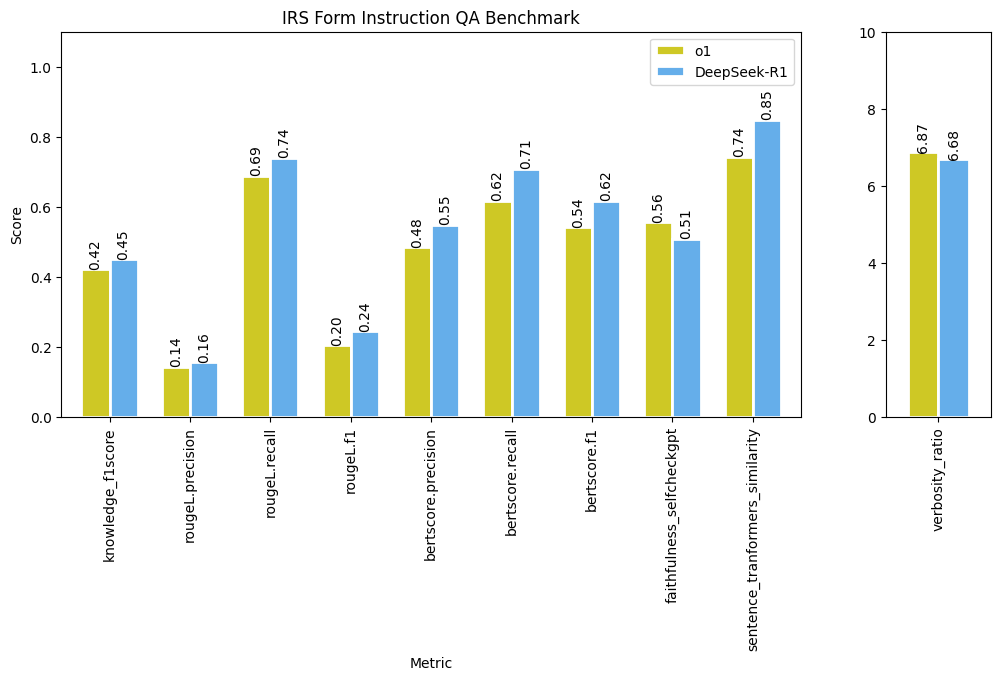

In [85]:
# Merge the two runs into one DataFrame for easier plotting
o1_stats = o1_results_df.describe().loc['mean']
o1_stats.name = "o1"

deepseek_stats = deepseek_results_df.describe().loc['mean'].drop(index=['rougeL', 'bertscore'])
deepseek_stats.name = "DeepSeek-R1"

experiments = pd.concat([o1_stats, deepseek_stats], axis=1)

# Plot the results from the two runs
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [7, 1]}, figsize=(12,5))

experiments.drop(
  ['verbosity_ratio']
  ).plot(
    ax=a0, 
    kind='bar',
    ylim=[0,1.1],
    width=0.7,
    xlabel='Metric',
    ylabel="Score",
    title='IRS Form Instruction QA Benchmark',
    color=["#CEC825", "#65AEEA"],
    edgecolor="w", 
    linewidth=2
  )

experiments.loc[
  ['verbosity_ratio']
  ].plot(
    ax=a1,
    kind='bar',
    ylim=[0,10],
    width=0.7,
    legend=False,
    color=["#CEC825", "#65AEEA"],
    edgecolor="w", 
    linewidth=2
    )

for container in a1.containers:
  a1.bar_label(container, fmt='%.2f', rotation=90)

for container in a0.containers:
  a0.bar_label(container, fmt='%.2f', rotation=90)

Across nearly all metrics, `DeepSeek-R1` considerably outperforms OpenAI's `o1` model. Both models are fairly verbose, indicating that the `max_tokens` parameter can be lowered (though this may risk incomplete model responses due to the tokens used during reasoning). Interestingly, `o1` outperforms `DeepSeek-R1` in the faithfulness metric. To better understand why, let's look at the worst performing rows on `faithfulness_selfcheckgpt` for each model.

In [97]:
# First, we should remove out the thinking portion of the DeepSeek-R1 model output
deepseek_results_df['output_cleaned'] = deepseek_results_df['output'].str.split("</think>").str[-1]


print("Worst Faithfulness performers\n")

with pd.option_context('display.max_colwidth', 0):

  print("o1:")
  display(o1_results_df.sort_values('faithfulness_selfcheckgpt', ascending=True)[['context', 'output', 'faithfulness_selfcheckgpt']].head(2))

  print("\n")
  print("DeepSeek-R1:")
  display(deepseek_results_df.sort_values('faithfulness_selfcheckgpt', ascending=True)[['context', 'output_cleaned', 'faithfulness_selfcheckgpt']].head(2))


Worst Faithfulness performers

o1:


,context,output,faithfulness_selfcheckgpt
36,"4.\n\n\_\_\_\_\_\n\n \n\n \n\n \n![This is an Image: caution.gif](/pub/xml_bc/caution.gif) Electing to include nontaxable combat pay may increase or decrease your EIC. Figure the credit with and without your nontaxable combat pay before making the election.\n\n \n\n**5.**\n\nAdd lines 3 and 4. \n**This is your earned income**\n\n**5.**\n\n\_\_\_\_\_\n\n \n\n \n\n \n\n**2\.** Were you self-employed at any time in 2024, or are you filing Schedule SE because you were a member of the clergy or you had church employee income, or are you filing Schedule C as a statutory employee?\n\n \n\n![This is an Image: squ.gif](/pub/xml_bc/squ.gif)\n\n\[ \]\n\n**Yes.**\n\nSkip question 3 and Step 6; go to Worksheet B.\n\n \n\n![This is an Image: squ.gif](/pub/xml_bc/squ.gif)\n\n\[ \]\n\n**No.**\n\n**3\.** If you have:\n\n* 3 or more qualifying children who have valid SSNs, is your earned income less than $59,899 ($66,819 if married filing jointly)?\n \n* 2 qualifying children who have valid SSNs, is your earned income less than $55,768 ($62,688 if married filing jointly)?\n \n* 1 qualifying child who has a valid SSN, is your earned income less than $49,084 ($56,004 if married filing jointly)?\n \n* No qualifying children who have valid SSNs, is your earned income less than $18,591 ($25,511 if married filing jointly)?\n \n\n \n\n![This is an Image: squ.gif](/pub/xml_bc/squ.gif)\n\n\[ \]\n\n**Yes.**\n\nGo to Step 6.\n\n \n\n![This is an Image: squ.gif](/pub/xml_bc/squ.gif)\n\n\[ \]\n\n**No.**\n\nYou can't take the credit.\n\n##### Step 6. How To Figure the Credit\n\n**1\.** Do you want the IRS to figure the credit for you?\n\n \n\n![This is an Image: squ.gif](/pub/xml_bc/squ.gif)\n\n\[ \]\n\n**Yes.**\n\nSee Credit figured by the IRS, later.\n\n \n\n![This is an Image: squ.gif](/pub/xml_bc/squ.gif)\n\n\[ \]\n\n**No.**\n\nGo to Worksheet A.\n\n#### Definitions and Special Rules\n\n**Adopted child.**\n\nAn adopted child is always treated as your own child. An adopted child includes a child lawfully placed with you for legal adoption.\n\n**Church employees.**","If you want to include your **nontaxable combat pay** in your **Earned Income Credit (EIC)** calculation, you can choose to do so by making an election on your tax return. Including nontaxable combat pay may increase or decrease your EIC, so it's important to calculate the credit both ways to determine which option is more beneficial for you.\n\nHere are the steps you should follow:\n\n1. **Locate Your Nontaxable Combat Pay Amount:**\n - Find your Form W-2 from your military employer.\n - Look for Box 12 with Code Q; this box reports your nontaxable combat pay.\n\n2. **Calculate the EIC Both Ways:**\n - **Without Nontaxable Combat Pay:**\n - Use your earned income excluding nontaxable combat pay.\n - Complete the EIC Worksheet (usually found in the IRS instructions for Form 1040) using this amount.\n - **With Nontaxable Combat Pay:**\n - Add your nontaxable combat pay to your earned income.\n - Complete a second EIC Worksheet using this new total.\n\n3. **Compare the Results:**\n - Determine which calculation provides a higher EIC amount.\n\n4. **Make the Election:**\n - If including the nontaxable combat pay results in a higher EIC (or if you prefer to include it for any reason), you can elect to include it.\n - On your tax return (Form 1040), there is a designated line or checkbox to indicate this election. For the correct placement:\n - Refer to the instructions for the specific tax year you are filing, as line numbers may change.\n - Typically, you will enter the amount of your nontaxable combat pay on the line labeled ""Nontaxable combat pay election.""\n\n5. **Complete Your Tax Return:**\n - Continue filling out your tax return using the information from the EIC Worksheet that includes your elected nontaxable combat pay, if you've chosen to include it.\n - Attach any required forms or schedules as instructed.\n\n**Additional Tips:**\n\n- **Do



DeepSeek-R1:


,context,output_cleaned,faithfulness_selfcheckgpt
36,"4.\n\n\_\_\_\_\_\n\n \n\n \n\n \n![This is an Image: caution.gif](/pub/xml_bc/caution.gif) Electing to include nontaxable combat pay may increase or decrease your EIC. Figure the credit with and without your nontaxable combat pay before making the election.\n\n \n\n**5.**\n\nAdd lines 3 and 4. \n**This is your earned income**\n\n**5.**\n\n\_\_\_\_\_\n\n \n\n \n\n \n\n**2\.** Were you self-employed at any time in 2024, or are you filing Schedule SE because you were a member of the clergy or you had church employee income, or are you filing Schedule C as a statutory employee?\n\n \n\n![This is an Image: squ.gif](/pub/xml_bc/squ.gif)\n\n\[ \]\n\n**Yes.**\n\nSkip question 3 and Step 6; go to Worksheet B.\n\n \n\n![This is an Image: squ.gif](/pub/xml_bc/squ.gif)\n\n\[ \]\n\n**No.**\n\n**3\.** If you have:\n\n* 3 or more qualifying children who have valid SSNs, is your earned income less than $59,899 ($66,819 if married filing jointly)?\n \n* 2 qualifying children who have valid SSNs, is your earned income less than $55,768 ($62,688 if married filing jointly)?\n \n* 1 qualifying child who has a valid SSN, is your earned income less than $49,084 ($56,004 if married filing jointly)?\n \n* No qualifying children who have valid SSNs, is your earned income less than $18,591 ($25,511 if married filing jointly)?\n \n\n \n\n![This is an Image: squ.gif](/pub/xml_bc/squ.gif)\n\n\[ \]\n\n**Yes.**\n\nGo to Step 6.\n\n \n\n![This is an Image: squ.gif](/pub/xml_bc/squ.gif)\n\n\[ \]\n\n**No.**\n\nYou can't take the credit.\n\n##### Step 6. How To Figure the Credit\n\n**1\.** Do you want the IRS to figure the credit for you?\n\n \n\n![This is an Image: squ.gif](/pub/xml_bc/squ.gif)\n\n\[ \]\n\n**Yes.**\n\nSee Credit figured by the IRS, later.\n\n \n\n![This is an Image: squ.gif](/pub/xml_bc/squ.gif)\n\n\[ \]\n\n**No.**\n\nGo to Worksheet A.\n\n#### Definitions and Special Rules\n\n**Adopted child.**\n\nAn adopted child is always treated as your own child. An adopted child includes a child lawfully placed with you for legal adoption.\n\n**Church employees.**","\n\nTo include nontaxable combat pay in your Earned Income Credit (EIC) calculation, follow these steps:\n\n1. **Compare Both Scenarios**: \n - Calculate your EIC **with** nontaxable combat pay included in earned income. \n - Calculate your EIC **without** including nontaxable combat pay. \n - Use whichever method results in a **higher credit**.\n\n2. **How to Include Combat Pay**: \n - Add your nontaxable combat pay to your earned income on **Line 4** of the worksheet. \n - Combine this amount with other earned income on **Line 5** to determine your total earned income for EIC purposes.\n\n3. **Check Income Limits**: \n Ensure your total earned income (including combat pay, if elected) does not exceed the EIC income thresholds for your filing status and number of qualifying children (listed in **Question 3** of the context). Exceeding these limits disqualifies you from the credit.\n\n4. **Documentation**: \n If you elect to include combat pay, no special form is required. Simply include it in your earned income calculation. Retain documentation of your combat pay (e.g., Leave and Earnings Statement) in case of an IRS inquiry.\n\n**Why This Matters**: \nIncluding nontaxable combat pay can sometimes increase your EIC, but it depends on your income level and family size. Always verify both scenarios to maximize your benefit. If you’re unsure, use the IRS’s EIC Assistant tool or consult a tax professional.",0.150244
47,"You may be able to increase an education credit if the student chooses to include all or part of a Pell grant or certain other scholarships or fellowships in income.\n\nFor more information, see Pub. 970; the instructions for Form 1040 or 1040-SR, line 29; and [IRS.gov/EdCredit](https://www.irs.gov/EdCredit).\n\n#### Line 4\n\n##### Retirement Savings Contributions Credit (Saver's Credit)\n\nYou may be able to take this credit 

You can see that in **both** `o1` and `DeepSeek-R1`, their responses fully and correctly define the EIC acronym as "Earned Income Credit". However, because the context does not contain the full definition for the acronym, their responses are considered a hallucination.

You can also see that the second examples for each model contain URLs in the outputs. `o1`'s output only contains URLs that can be found in the context; however, `DeepSeek-R1`'s output contains a link for Form 8880 that is not present in the context, resulting in a hallucination. 

These hallucinations can likely be mitigated through better prompting to achieve better results. Thus, due to the smaller size, lower cost, and superior performance, we would likely continue to iterate on the prompt for `DeepSeek-R1`. 

## Support
For assistance and inquiries: [support@quotientai.co](mailto:support@quotientai.co)